Import Dependencies

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# find the data directory and extract each CSV file
path = "data"
allFiles = glob.glob(os.path.join(path, "*.csv"))  
np_array_list = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    # get symbol name from file
#     df['Symbol'] = (file_.split('/')[1]).split(".")[0]
    # pull only needed fields
    df = df[['Symbol','Date', 'Adj Close']]
    np_array_list.append(df.to_numpy())
    
# stack all arrays and tranfer it into a data frame
comb_np_array = np.vstack(np_array_list)  
# simplify column names
stock_data_raw = pd.DataFrame(comb_np_array, columns = ['Symbol','Date', 'Close'])
# fix datetime data
stock_data_raw['Date'] = pd.to_datetime(stock_data_raw['Date'], infer_datetime_format=True)
stock_data_raw['Date'] = stock_data_raw['Date'].dt.date

# check for NAs
stock_data_raw = stock_data_raw.dropna(axis=1, how='any')

# quick hack to get the column names (i.e. whatever stocks you loaded)
stock_data_tmp = stock_data_raw.copy()

# make symbol column header
stock_data_raw = stock_data_raw.pivot('Date','Symbol')
stock_data_raw.columns = stock_data_raw.columns.droplevel()
# collect correct header names (actual stocks)
column_names = list(stock_data_raw)

stock_data_raw.tail()

Symbol,COKE,FDX,PEP,UPS
Date,,,,
2021-02-12,277.4,263,133.87,162.362
2021-02-16,273.73,261.83,134.38,160.732
2021-02-17,271.77,259.09,134.46,159.987
2021-02-18,268.6,255.63,135.37,161.1
2021-02-19,264.88,254.64,132.51,160.54


In [3]:
# hack to remove mult-index stuff
stock_data_raw = stock_data_tmp[['Symbol', 'Date', 'Close']]
stock_data_raw = stock_data_raw.pivot('Date','Symbol')
stock_data_raw.columns = stock_data_raw.columns.droplevel(-1)
stock_data_raw.columns = column_names

# replace NaNs with previous value
stock_data_raw.fillna(method='bfill', inplace=True) 

stock_data_raw.tail()

,COKE,FDX,PEP,UPS
Date,,,,
2021-02-12,277.399994,263.000000,133.869995,162.362015
2021-02-16,273.730011,261.829987,134.380005,160.732330
2021-02-17,271.769989,259.089996,134.460007,159.987045
2021-02-18,268.600006,255.630005,135.369995,161.099991
2021-02-19,264.880005,254.639999,132.509995,160.539993


In [4]:
stock_data = stock_data_raw.copy()

Plot paired stocks on different axes

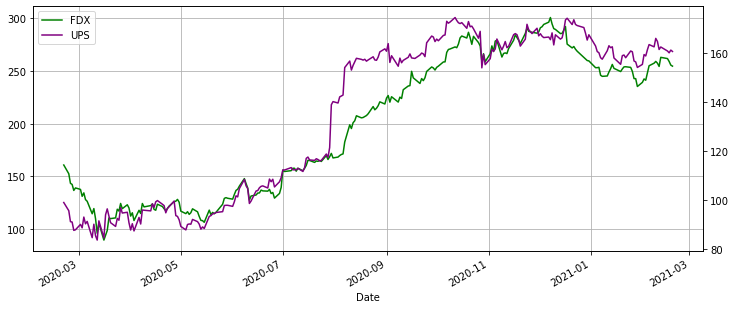

In [5]:
plt.figure(figsize=(12,5))
ax1 = stock_data['FDX'].plot(color='green', grid=True, label='FDX')
ax2 = stock_data['UPS'].plot(color='purple', grid=True, secondary_y=True, label='UPS')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()


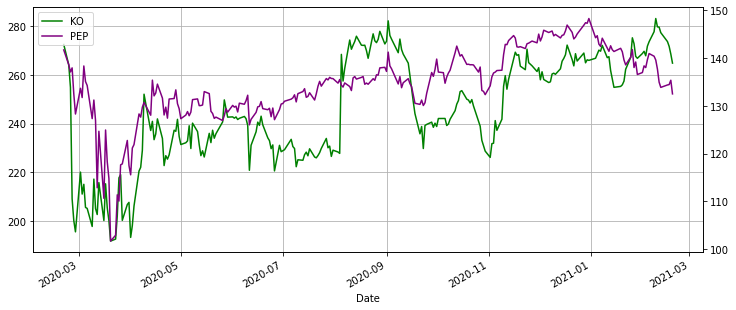

In [6]:
plt.figure(figsize=(12,5))
ax1 = stock_data['COKE'].plot(color='green', grid=True, label='KO')
ax2 = stock_data['PEP'].plot(color='purple', grid=True, secondary_y=True, label='PEP')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

Normalize Data

In [7]:
def normalize_and_accumulate_series(data):
    # take tail to drop head NA
    return data.pct_change().cumsum()

stock_data['FDX'] = normalize_and_accumulate_series(stock_data['FDX'])
stock_data['UPS'] = normalize_and_accumulate_series(stock_data['UPS'])
stock_data['COKE'] = normalize_and_accumulate_series(stock_data['COKE'])
stock_data['PEP'] = normalize_and_accumulate_series(stock_data['PEP'])

# remove first row with NAs 
stock_data = stock_data.tail(len(stock_data)-1)

In [8]:
stock_data.head()

,COKE,FDX,PEP,UPS
Date,,,,
2020-02-24,-0.030839,-0.051455,-0.022009,-0.033749
2020-02-25,-0.065751,-0.111190,-0.032805,-0.080353
2020-02-26,-0.245374,-0.118539,-0.026569,-0.082163
2020-02-27,-0.288136,-0.158462,-0.066081,-0.119397
2020-02-28,-0.311218,-0.141093,-0.097907,-0.116627


Plot Paired stocks on same axes

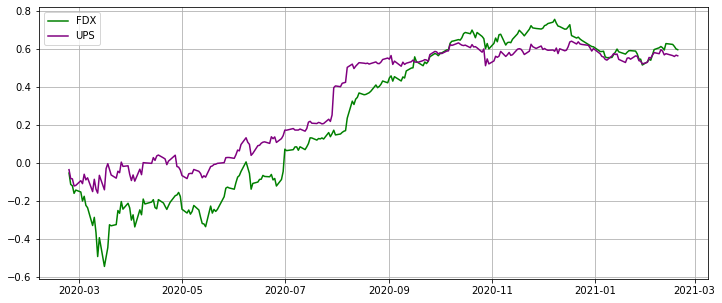

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data['FDX'], color='green', label='FDX')
plt.plot(stock_data['UPS'], color='purple', label='UPS')
ax.grid(True)
plt.legend(loc=2)
plt.show()

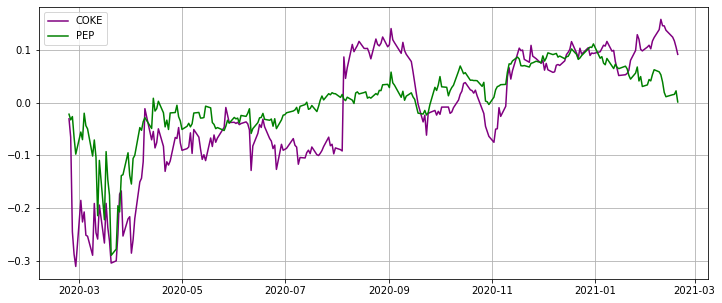

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data['COKE'], color='purple', label='COKE')
plt.plot(stock_data['PEP'], color='green', label='PEP')
ax.grid(True)
plt.legend(loc=2)
plt.show()

Getting some Statistical Measurements (mean, std, corr)

In [11]:
# pip install scipy
# pip install statsmodels
from statsmodels.tsa.stattools import coint

def corr(data1, data2):
    "data1 & data2 should be numpy arrays."
    mean1 = data1.mean() 
    mean2 = data2.mean()
    std1 = data1.std()
    std2 = data2.std()
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2)
    return corr

In [12]:
# Target - we want to select a pair of stocks with HIGH correlation and LOW cointegration
# Cointegration (distance between the two stocks) to be less than 0.05 to be statistically significant
# Correlation (direction they move) - they move close to 1 (high correlation)
stock_name_1 = 'UPS'
stock_name_2 = 'FDX'

score, pvalue, _ = coint(stock_data[stock_name_1], stock_data[stock_name_2])
correlation = corr(stock_data[stock_name_1], stock_data[stock_name_2])

print('Correlation between %s and %s is %f' % (stock_name_1, stock_name_2, correlation))
print('Cointegration between %s and %s is %f' % (stock_name_1, stock_name_2, pvalue))

Correlation between UPS and FDX is 0.973939
Cointegration between UPS and FDX is 0.041849


In [13]:
stock_name_1 = 'COKE'
stock_name_2 = 'PEP'

score, pvalue, _ = coint(stock_data[stock_name_1], stock_data[stock_name_2])
correlation = corr(stock_data[stock_name_1], stock_data[stock_name_2])

print('Correlation between %s and %s is %f' % (stock_name_1, stock_name_2, correlation))
print('Cointegration between %s and %s is %f' % (stock_name_1, stock_name_2, pvalue))

Correlation between COKE and PEP is 0.822259
Cointegration between COKE and PEP is 0.017612


Measuring Separation and Spikes Highlights - We simply subtract the two related and normalized series of "pairs of stocks"

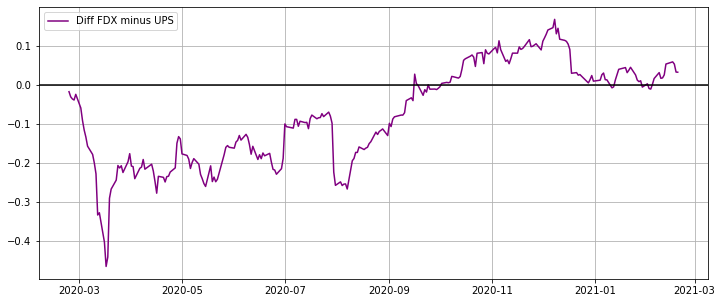

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data['FDX'] - stock_data['UPS'], color='purple', label='Diff FDX minus UPS')
ax.grid(True)
ax.axhline(y=0, color='black', linestyle='-') 
plt.legend(loc=2)
plt.show()

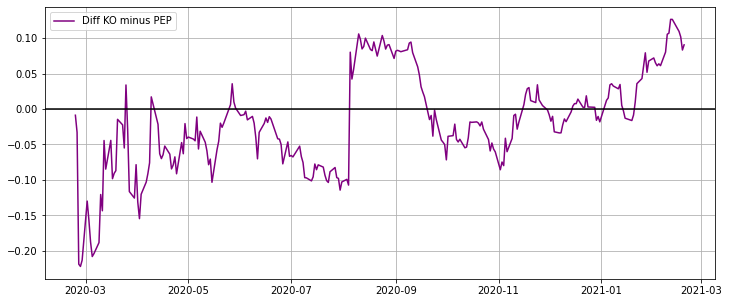

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data['COKE'] - stock_data['PEP'], color='purple', label='Diff KO minus PEP')
ax.grid(True)
ax.axhline(y=0, color='black', linestyle='-') 
plt.legend(loc=2)
plt.show()

Desiging Spike Thresholds (Percentage Changes)

In [21]:
# get the original data set
stock_data = stock_data_raw.copy()

In [22]:
def normalize_series(data):
    # take tail to drop head NA
    return data.pct_change()

stock_data['FDX'] = normalize_series(stock_data['FDX'])
stock_data['UPS'] = normalize_series(stock_data['UPS'])
stock_data['COKE'] = normalize_series(stock_data['COKE'])
stock_data['PEP'] = normalize_series(stock_data['PEP'])

# remove first row with NAs 
stock_data = stock_data.tail(len(stock_data)-1)

In [23]:
stock_data.head()

,COKE,FDX,PEP,UPS
Date,,,,
2020-02-24,-0.030839,-0.051455,-0.022009,-0.033749
2020-02-25,-0.034912,-0.059735,-0.010796,-0.046604
2020-02-26,-0.179623,-0.007349,0.006237,-0.001810
2020-02-27,-0.042762,-0.039923,-0.039513,-0.037235
2020-02-28,-0.023082,0.017368,-0.031825,0.002770


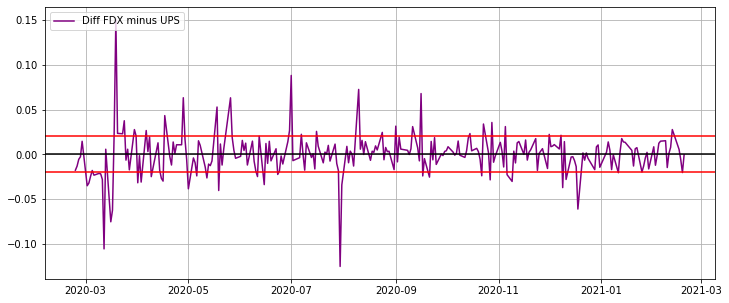

In [24]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data['FDX'] - stock_data['UPS'], color='purple', label='Diff FDX minus UPS')
ax.grid(True)
ax.axhline(y=0, color='black', linestyle='-') 
ax.axhline(y=0.02, color='red', linestyle='-') 
ax.axhline(y=-0.02, color='red', linestyle='-')
plt.legend(loc=2)
plt.show()

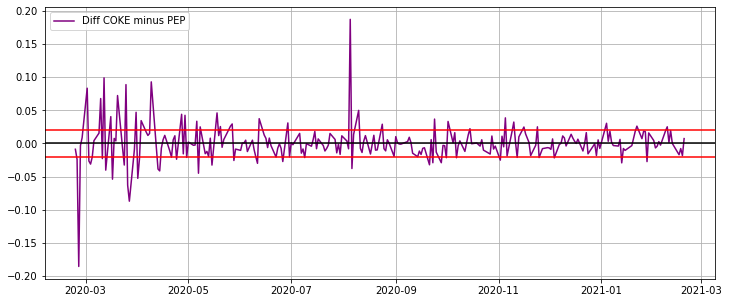

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(stock_data['COKE'] - stock_data['PEP'], color='purple', label='Diff COKE minus PEP')
ax.grid(True)
ax.axhline(y=0, color='black', linestyle='-') 
ax.axhline(y=0.02, color='red', linestyle='-') 
ax.axhline(y=-0.02, color='red', linestyle='-') 
plt.legend(loc=2)
plt.show()